In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from exp.nb_Tesis import *

In [3]:
# !wget https://challenge.kitware.com/api/v1/item/5ac37a9d56357d4ff856e176/download

In [4]:
# !wget https://challenge.kitware.com/api/v1/item/5ac3695656357d4ff856e16a/download

In [5]:
# !unzip download

In [14]:
path = Path('./seg_data')

In [23]:
path_lbl = path/'modified_labels'
path_img = path/'train_images'

In [24]:
fnames = get_image_files(path_img)
fnames[:3]


[PosixPath('seg_data/train_images/ISIC_0009974.jpg'),
 PosixPath('seg_data/train_images/ISIC_0000046.jpg'),
 PosixPath('seg_data/train_images/ISIC_0013617.jpg')]

In [25]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]


[PosixPath('seg_data/modified_labels/ISIC_0014195_segmentation.png'),
 PosixPath('seg_data/modified_labels/ISIC_0013359_segmentation.png'),
 PosixPath('seg_data/modified_labels/ISIC_0000543_segmentation.png')]

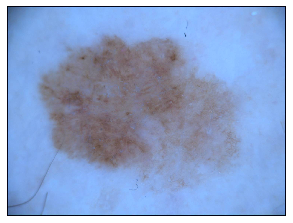

In [27]:
img_f = fnames[1]
img = open_image(img_f)
img.show(figsize=(5,5))

In [28]:
img.shape

torch.Size([3, 1129, 1504])

In [29]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_segmentation.png'

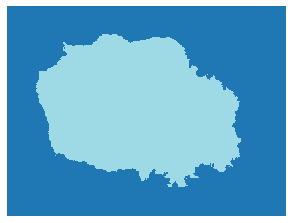

In [30]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [31]:
src_size = np.array(mask.shape[1:])
src_size,mask

(array([1129, 1504]), ImageSegment (1, 1129, 1504))

In [32]:
mask.data.unique()

tensor([0, 1])

In [33]:
codes = ['Lession', 'Other']

# Load the data

In [34]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [35]:
# size = src_size//10
size = 224

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11164MB of GPU RAM free


In [36]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [37]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=8)
        .normalize())

In [38]:
bs

8

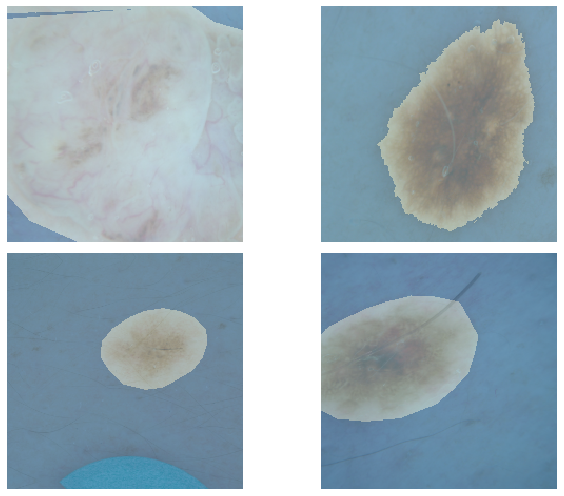

In [39]:
data.show_batch(2, figsize=(10,7))

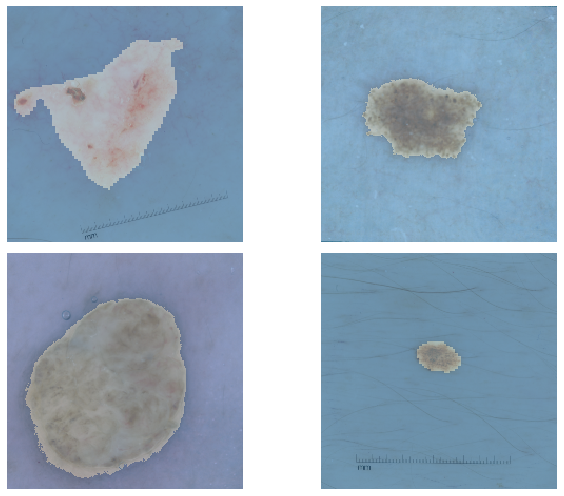

In [40]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

# Model

#### reset memory

In [41]:
torch.cuda.empty_cache()
gc.collect()

38693

In [42]:
!nvidia-smi

Mon May 25 18:37:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:01:00.0 Off |                  N/A |
| 23%   36C    P2    55W / 250W |    393MiB / 11176MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!export CUDA_VISIBLE_DEVICES=1

In [86]:
!nvidia-smi

Mon Nov 25 17:46:41 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   38C    P2    56W / 250W |   5581MiB / 11177MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:09:00.0 Off |                  N/A |
|  0%   23C    P8     7W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

#### define accuracy

In [43]:
name2id = {v:k for k,v in enumerate(codes)}
# void_code = name2id['Other']

def acc_camvid(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [44]:
metrics=acc_camvid
# metrics=accuracy

In [46]:
wd=1e-2

In [47]:
learn = unet_learner(data, 
                     models.resnet34,metrics=[dice],
                     callback_fns=[
                         ShowGraph,
                         ActivationStats,
                     ], 
                     wd=wd)

In [48]:
lr=3e-3

In [34]:
# del learn
# del data

torch.cuda.empty_cache()
gc.collect()

20

epoch,train_loss,valid_loss,dice,time
0,0.312988,0.234191,0.780865,02:32
1,0.216519,0.172118,0.839659,02:25


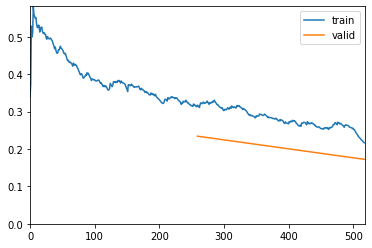

Better model found at epoch 0 with valid_loss value: 0.23419106006622314.
Better model found at epoch 1 with valid_loss value: 0.17211802303791046.


In [49]:
learn.fit_one_cycle(2, slice(3e-4), pct_start=0.9,callbacks = [
    SaveModelCallback(learn=learn),
])

In [ ]:
# model_summary(learn)
learn.show_results??

In [50]:
learn.save('segmenter-stage-1')

In [43]:
learn.load('bestmodel');

In [79]:
learn.show_results??

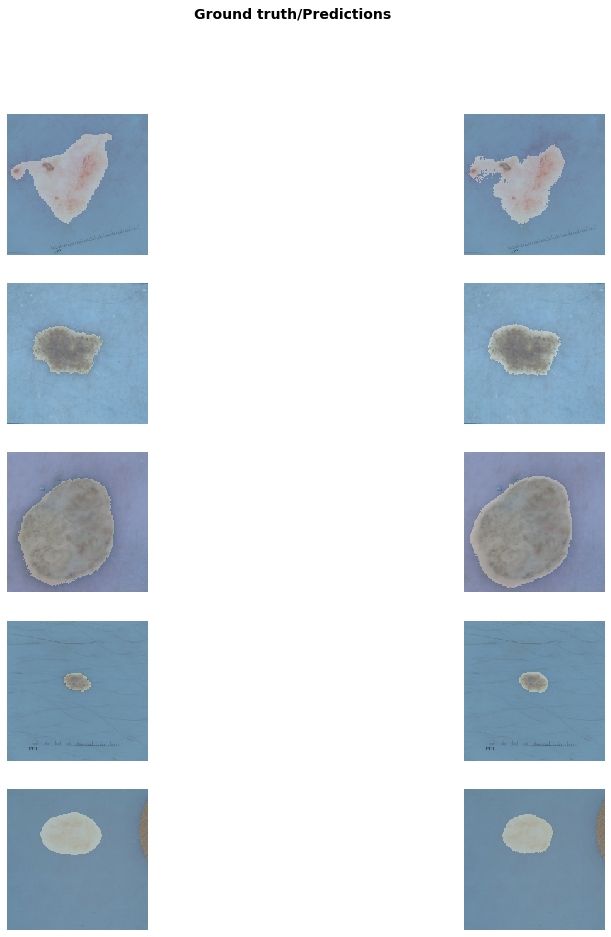

In [51]:
learn.show_results(rows=5, figsize=(15,15))

In [52]:
learn.unfreeze()

In [53]:
lrs = slice(lr/400,lr/4)

epoch,train_loss,valid_loss,dice,time
0,0.200301,0.159840,0.847860,02:27
1,0.188424,0.160859,0.845324,02:26
2,0.179840,0.150361,0.852907,02:30
3,0.179991,0.149528,0.858823,02:27
4,0.162250,0.135375,0.872819,02:26
5,0.155800,0.131617,0.873640,02:28
6,0.174473,0.128491,0.880707,02:27
7,0.138970,0.137140,0.876043,02:26
8,0.129790,0.128647,0.882278,02:26
9,0.111301,0.115184,0.891846,02:25


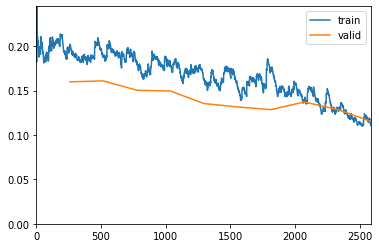

Better model found at epoch 0 with valid_loss value: 0.15984013676643372.
Better model found at epoch 2 with valid_loss value: 0.1503612995147705.
Better model found at epoch 3 with valid_loss value: 0.14952795207500458.
Better model found at epoch 4 with valid_loss value: 0.13537533581256866.
Better model found at epoch 5 with valid_loss value: 0.13161715865135193.
Better model found at epoch 6 with valid_loss value: 0.12849149107933044.
Better model found at epoch 9 with valid_loss value: 0.11518430709838867.


In [54]:
learn.fit_one_cycle(10, slice(1e-6,1e-4), pct_start=0.8,callbacks = [
    SaveModelCallback(learn=learn),
    ReduceLROnPlateauCallback(learn=learn)
])

In [55]:
learn.save('segmenter-stage-2')

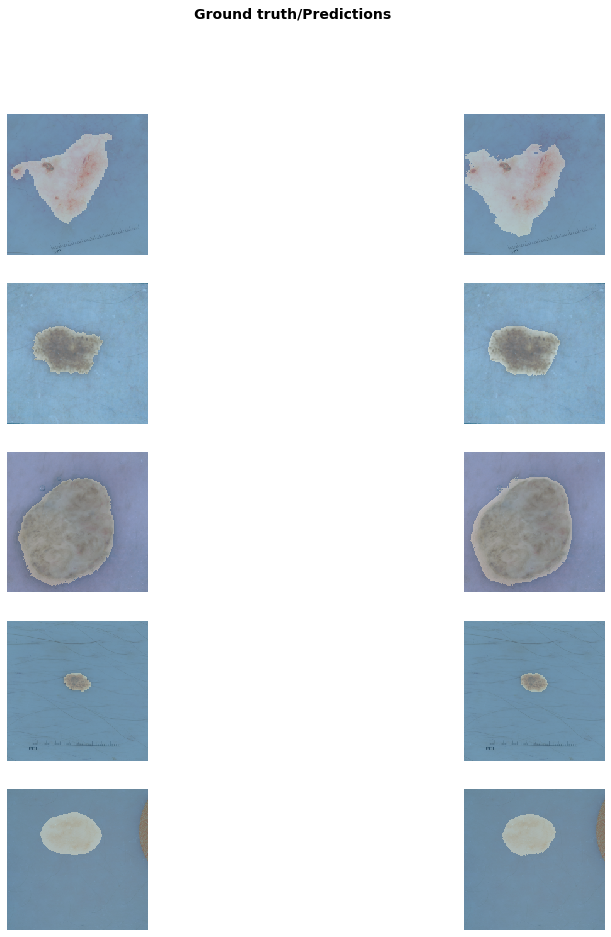

In [56]:
learn.show_results(rows=5, figsize=(15,15))

In [57]:
learn.export(file='segmenter_224.pkl')